# 使用国内资产复现bender的论文

In [1]:
import os, sys, argparse, logging

import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['font.family'] = 'SimHei'
plt.rcParams['axes.unicode_minus'] = False

import pandas as pd
import numpy as np
from datetime import datetime
from copy import deepcopy
from tqdm import tqdm

this_path = os.path.abspath('.')
if this_path not in sys.path:
    sys.path.append(this_path)

from factor_portfolio import *
from load_data import *
from backtest import *

## 1.按步骤分解

In [2]:
# 读入资产数据
asset_data = getAssetData().fillna(method='ffill').rolling(22).mean()

# 读入因子数据
factor_data = getFactorData().reindex(asset_data.index).fillna(method='ffill').rolling(22).mean()

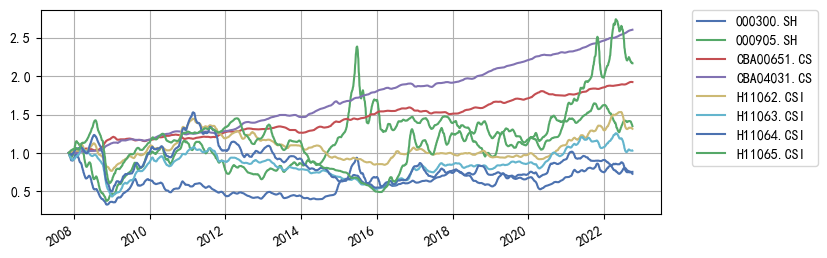

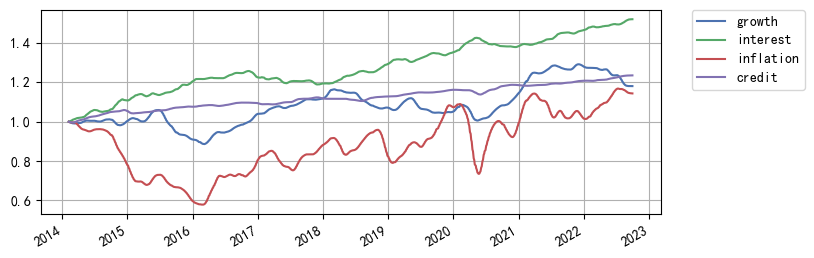

In [3]:
(asset_data.dropna()/asset_data.dropna().iloc[0]).plot(figsize=(8,3), grid=True)
plt.legend(loc=2, bbox_to_anchor=(1.05,1.0),borderaxespad = 0.)

(factor_data.dropna()/factor_data.dropna().iloc[0]).plot(figsize=(8,3), grid=True)
plt.legend(loc=2, bbox_to_anchor=(1.05,1.0),borderaxespad = 0.)

In [4]:
id_date = datetime(2019, 8, 31)
look_back = 252 * 3

tmp_asset_data = asset_data.loc[:id_date].iloc[-look_back:]
tmp_factor_data = factor_data.loc[:id_date].iloc[-look_back:]

asset_returns = tmp_asset_data.pct_change().fillna(0)
factor_returns = tmp_factor_data.pct_change().fillna(0)



### Step 2： Estimating Asset Class Factor Exposures

In [5]:
exposure = getFatorExposureFrame(asset_returns, factor_returns)
exposure

,growth,interest,inflation,credit
000300.SH,1.313710,-0.595373,-0.578783,0.160006
000905.SH,1.452304,-0.088930,-0.756505,-0.205415
CBA00651.CS,-0.563210,1.763759,-1.018777,-1.274049
CBA04031.CS,-0.643708,1.149002,-1.246571,2.009929
H11062.CSI,-1.431157,-0.946713,0.470041,0.044006
H11063.CSI,0.073934,-0.553981,0.951369,-0.622843
H11064.CSI,-0.524824,-0.971578,1.077173,-0.716532
H11065.CSI,0.322950,0.243814,1.102053,0.604898


### Step 3: Constructing Factor-Mimicking Portfolios

In [6]:
fmp = getFactorMimickingPortfolio(asset_returns, factor_returns, scale=1)
fmp

,growth,interest,inflation,credit
000300.SH,0.173922,-0.262891,-0.272675,-0.127904
000905.SH,0.037475,0.070518,0.100194,0.045969
CBA00651.CS,-0.090532,0.064516,-0.094447,-0.263335
CBA04031.CS,0.021243,0.122248,0.044278,0.308517
H11062.CSI,-0.409468,-0.227310,-0.090345,-0.087190
H11063.CSI,0.257554,0.204278,0.314947,0.126687
H11064.CSI,0.004288,-0.009798,-0.042533,-0.021571
H11065.CSI,0.005519,0.038441,0.040581,0.018827


## 2. 回测

In [7]:
date_range = [datetime(2018,1,1), datetime(2019,12,31)]

In [8]:
# fmp回测表现
class FmpStrategy(Strategy):
    def __init__(self, factor_data=None, factor_name=None, scale=1):
        super().__init__()
        self._factor_data = factor_data
        self._factor_name = factor_name
        self._scale = scale

    def run(self, asset_data):
        tmp_asset_returns = asset_data.pct_change().fillna(0)
        tmp_factor_data = self._factor_data.reindex(asset_data.index)
        tmp_factor_returns = tmp_factor_data.pct_change().fillna(0)

        return getFactorMimickingPortfolio(tmp_asset_returns, tmp_factor_returns, scale=self._scale)[self._factor_name]
      

In [9]:
fmp_value = pd.DataFrame()
fmp_weights = {}

for factor in factor_data.columns:
    fmp_backtest = BacktestManager(
        FmpStrategy(factor_data=factor_data, factor_name=factor, scale=None), 
        asset_data, 
        date_range = date_range, 
        frequency = 252//12, 
        look_back = 252*3, 
    )
    fmp_backtest.run()
    fmp_value[factor] = fmp_backtest.getHistoricalValue()
    weights_dict = fmp_backtest._historcial_weights
    fmp_weights[factor] = pd.DataFrame(columns=asset_data.columns)
    for id_date, weights in weights_dict.items():
        fmp_weights[factor].loc[id_date] = weights.reindex(fmp_weights[factor].columns)



100%|██████████| 487/487 [00:03<00:00, 153.92it/s]


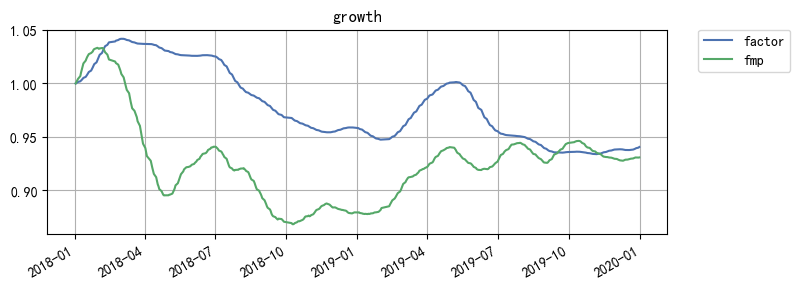

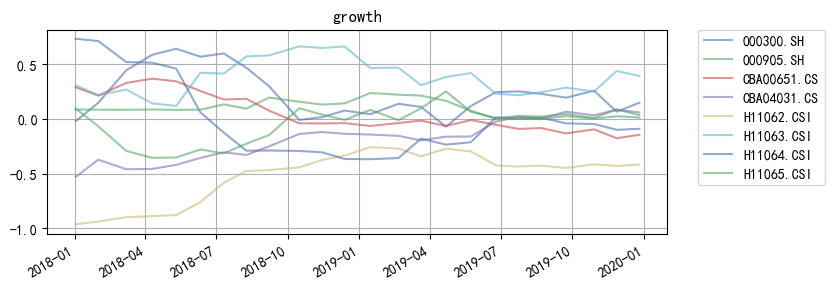

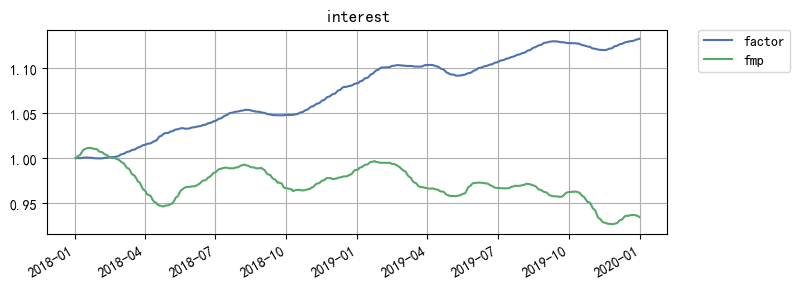

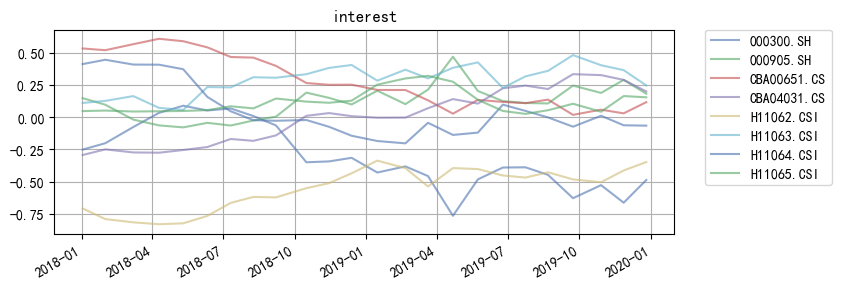

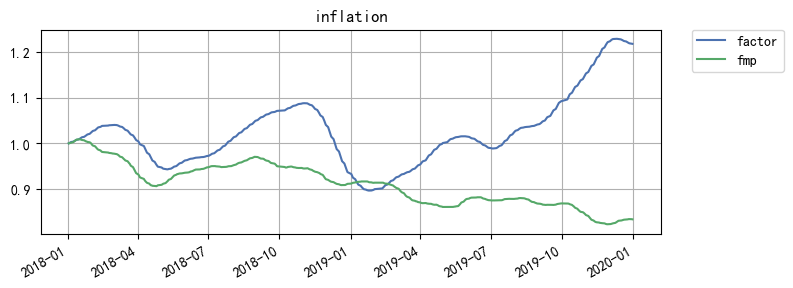

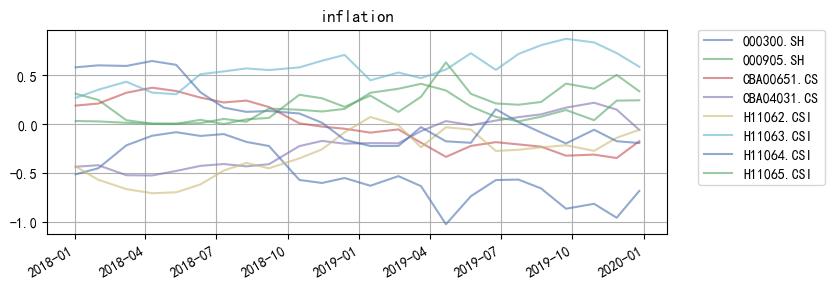

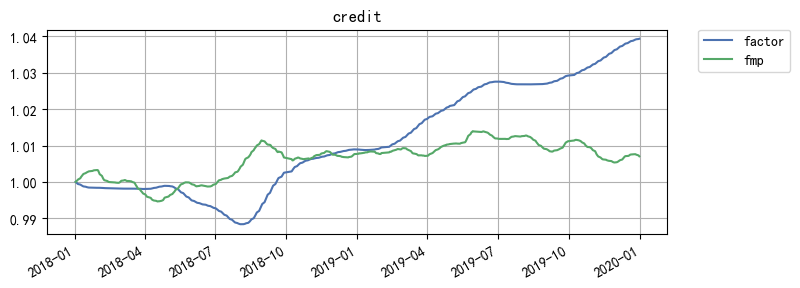

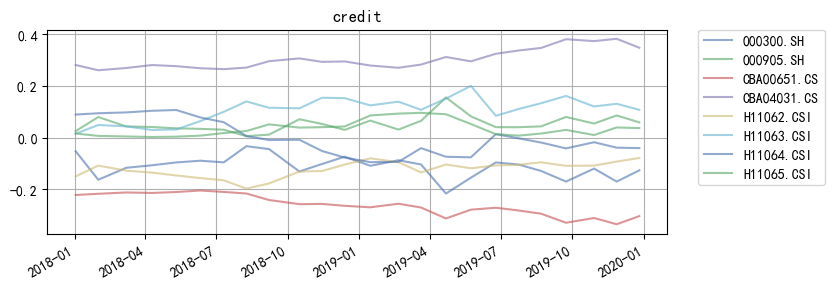

In [10]:
tmp_factor_data = factor_data.reindex(fmp_value.index)
tmp_factor_data /= tmp_factor_data.iloc[0]
fmp_value /= fmp_value.iloc[0]

for factor in factor_data.columns:
    pd.DataFrame({
        'factor': tmp_factor_data[factor], 
        'fmp': fmp_value[factor], 
    }).plot(figsize=(8,3), grid=True, title=factor)
    plt.legend(loc=2, bbox_to_anchor=(1.05,1.0),borderaxespad = 0.)

    fmp_weights[factor].plot(figsize=(8,3), grid=True, title=factor, alpha=0.6)
    plt.legend(loc=2, bbox_to_anchor=(1.05,1.0),borderaxespad = 0.)



### Step 4: Forecasting Factor-Mimicking Portfolio Return

In [11]:
# 使用历史收益率作为fmp收益率预测
fmp_lookback = 252 * 1
fmp_return = fmp_value.loc[:id_date].iloc[-fmp_lookback:].pct_change().fillna(0)


### Step 5: Constructing the Optimal Factor Portfoli0

In [12]:
fmp_weights = optimalFactorPortfolio(fmp_return)

In [13]:
fmp_weights

,growth,interest,inflation,credit
0,1.0,8.326673e-17,4.510281e-17,0.0
